In [35]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.manifold import TSNE
from sentence_transformers.util import normalize_embeddings, semantic_search
from tqdm import tqdm

tqdm.pandas()

# EDA

In [2]:
df = pd.read_parquet('./__output__/train.parquet')
df = df[df['text'] != '']

df.head()

,nmId,text,responder,type,product_name,product_category_2,product_category_1,product_color,product_description,product_brand,__index_level_0__,vector,toxicity,emotions
0,7758359,"У меня сложилось впечатлением, что это Lovular...",Клиент,Отзыв,"Трусики-подгузники, Travel pack, XL 12-20 кг. ...",Подгузники детские,Товары для малышей,"мятный, белый",В упаковке 3 шт подгузников-трусиков в 3 разны...,Offspring,244202,"[0.035206687, -0.017458411, 0.050057203, 0.156...",non-toxic,no_emotion
1,3691804,"Добрый день! Благодарим за интерес, проявленны...",Магазин,Вопрос,HEPA фильтр FTH 08 для пылесосов SAMSUNG (Самс...,Фильтры для пылесосов,Бытовая техника,черный,Filtero FTH 08 НЕРА фильтр для пылесоса SAMSUN...,Filtero,1830972,"[-0.08458676, -0.043620594, 0.0068595554, 0.02...",non-toxic,joy
2,2148099,От сандалий не осталось ничего!!! Ни цвета ни ...,Клиент,Отзыв,Сандалии,Сандалии,Обувь,бежевый,,Flamingo,313600,"[-0.12766595, 0.19042678, 0.28017798, 0.015342...",non-toxic,joy
3,8023423,"Заказывала синий красный белый 46 размер,ткань...",Клиент,Вопрос,Сарафан,Сарафаны,Одежда,"синий, ярко-красный",Летний сарафан на бретельках из 100% хлопка-ку...,Агапэ,1158995,"[0.047446445, 0.32030234, 0.103780545, 0.00696...",non-toxic,no_emotion
4,5956211,"Добрый день, Вы взяли один размер в одном рост...",Магазин,Вопрос,Медицинские брюки из Satory,Брюки медицинские,Спецодежда и СИЗы,ярко-зеленый,"Медицинские брюки из ткани Сатори без стрейча,...",Med Fashion Lab,1548250,"[0.10665777, 0.018597584, 0.17656998, 0.103213...",non-toxic,sadness


In [3]:
df['emotions'].value_counts()

emotions
no_emotion    569413
joy           563630
sadness        89155
surprise       65869
anger           8762
fear            5138
Name: count, dtype: int64

In [4]:
df['toxicity'].value_counts()

toxicity
non-toxic    1298729
dangerous       2215
insult           743
threat           240
obscenity         40
Name: count, dtype: int64

In [9]:
mask = (df['emotions'] == 'anger') | \
(df['emotions'] == 'fear') | \
(df['toxicity'] == 'dangerous') | \
(df['toxicity'] == 'insult') | \
(df['toxicity'] == 'threat') | \
(df['toxicity'] == 'obscenity')

pos_df = df[~mask]
neg_df = df[mask]

neg_df

,nmId,text,responder,type,product_name,product_category_2,product_category_1,product_color,product_description,product_brand,__index_level_0__,vector,toxicity,emotions
104,7728617,"ДОБРОГО ВРЕМЕНИ СУТОК! БУДЬТЕ ДОБРЫ, ПОДСКАЖИТ...",Клиент,Вопрос,Футболка,Футболки,Одежда,белый,,Gulliver,1383398,"[0.17008908, 0.10877619, 0.05582178, -0.073754...",non-toxic,anger
230,8359265,"Пишу повторный отзыв, проработал в итоге не бо...",Клиент,Отзыв,Светильник настольный аккумуляторный,Светильники,Дом,черный,Светильние настольный Ultraflash предназначен ...,Ultraflash,128800,"[-0.023336649, -0.0033628214, 0.024340235, -0....",non-toxic,anger
322,3081307,цвет темнее чем на фото. чашечка одна была зал...,Клиент,Отзыв,Купальник,Раздельные купальники,Белье,синий,Формованная чашка с гелевым пуш-апом на каркас...,FIANETA,439944,"[0.03222534, 0.19630186, -0.07846444, 0.295757...",dangerous,no_emotion
380,6144081,"В нее можно дуть,как в дудку,или это просто по...",Клиент,Вопрос,Погремушка Горн,Погремушки,Игрушки,зеленый,Погремушка в форме горна из пластмассы. Звук с...,Bampi,1216858,"[0.08189797, -0.05039759, 0.10465885, 0.003125...",non-toxic,anger
458,88636591,"Ужасные стекла ,брал на Poco X 3, не достаёт п...",Клиент,Отзыв,Защитное стекло для Poco X3/ X3 Pro/ F3,Защитные стекла,Смартфоны и аксессуары,прозрачный,На все наши стекла распространяктся 40-дневная...,POCO,409071,"[-0.14631407, -0.10690308, 0.31674215, 0.01058...",non-toxic,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435269,43395620,"Отличные финики, крупные, вкусные и явно свежи...",Клиент,Отзыв,Финики сушеные 1 килограмм/Деглет Нур/Алжирские,Сухофрукты,Продукты,,Финики сорта Деглет Нур с косточкой внутри. На...,Nu_Aa,289814,"[0.03858127, -0.04472396, -0.041799344, 0.1706...",non-toxic,fear
1435518,102324783,"нормально, для своей цены хороши, шнурки были...",Клиент,Отзыв,Кроссовки nike air force 1 форсы,Кроссовки,Обувь,"белый, холодный белый, белый матовый",Кроссовки женские белые предназначены для несп...,KrossBox,344721,"[-0.20296763, 0.060336113, 0.19069918, -0.0377...",non-toxic,anger
1435684,5524454,Здравствуйте! Приносим извинения за Ваш негати...,Магазин,Отзыв,"Термопот настольный 4,5 л, кипятильник",Термопоты,Техника для кухни,,Электрический кипятильник (термопот) Gemlux GL...,Gemlux,522826,"[0.019145688, 0.030086005, 0.15169105, 0.09666...",non-toxic,anger
1435715,115456518,"Когда-то давно купила точно такой набор, но со...",Клиент,Отзыв,Набор из 6 тарелок в форме рыбок 19.6 х 16 см,Тарелки,Посуда и инвентарь,прозрачный,Блюдо фигурное Pasabahce Marine. Набор из шест...,Pasabahce,180949,"[-0.1364429, -0.051336, 0.16248755, 0.00368038...",non-toxic,anger


In [13]:
subset = neg_df.sample(5000)
manifolder = TSNE(n_components=2)

In [14]:
vectors = np.array(subset['vector'].to_list())
vectors = manifolder.fit_transform(vectors)

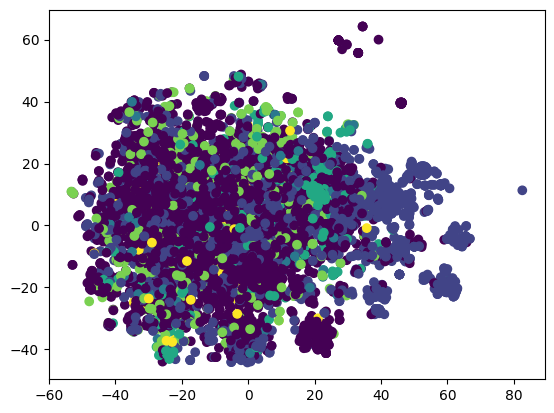

In [15]:
field = 'emotions'

mapper = {e: i for i, e in enumerate(subset[field].unique())}

plt.scatter(
    vectors[:, 0],
    vectors[:, 1],
    c=subset[field].apply(lambda e: mapper[e])
)

plt.show()

# Матчинг негатива с нормой

In [17]:
corpus = torch.FloatTensor(
    np.array(pos_df['vector'].to_list())
).to('cuda:0')

corpus = normalize_embeddings(corpus)

In [30]:
semantic_search(
    normalize_embeddings(
        torch.FloatTensor([neg_df.iloc[0]['vector']]).to('cuda:0')
    ),
    corpus
)

[[{'corpus_id': 72695, 'score': 0.8217299580574036},
  {'corpus_id': 1228083, 'score': 0.8149760365486145},
  {'corpus_id': 29511, 'score': 0.806286096572876},
  {'corpus_id': 974155, 'score': 0.8056544661521912},
  {'corpus_id': 323691, 'score': 0.8056530356407166},
  {'corpus_id': 326117, 'score': 0.8037558794021606},
  {'corpus_id': 655443, 'score': 0.8020350933074951},
  {'corpus_id': 608567, 'score': 0.8016837239265442},
  {'corpus_id': 586947, 'score': 0.7988957166671753},
  {'corpus_id': 536231, 'score': 0.7975293397903442}]]

In [33]:
neg_df.iloc[0]['text']

'ДОБРОГО ВРЕМЕНИ СУТОК! БУДЬТЕ ДОБРЫ, ПОДСКАЖИТЕ , ПОЖАЛУЙСТА БУДЕТ ЛИ В НАЛИЧИИ В БЛИЖАЙШЕЕ ВРЕМЯ РАЗМЕР 158 ИЛИ 164? ЖДУ ОТВЕТА. ЗАРАНЕЕ БЛАГОДАРЮ ВАС ЗА ПОМОЩЬ.'

In [34]:
pos_df.iloc[72695]['text']

'Здравствуйте , на размер 158 когда будет ожидаться? Или ожидается ли вообще?'

Изначально планировал искать матчи для негатива только из позитивных с тем же товаром, типом и респондентом, но из-за того, что пересечений между nmId у негатива и позитива недостаточно большое, пришлось матчить всех со всеми
Отбрасывать неудобные негативные тексты, так же не подходить, так как наш датасет уже и так достаточно мал

In [39]:
def get_match(e: np.ndarray):
    res = semantic_search(
        normalize_embeddings(
            torch.FloatTensor([e]).to('cuda:0')
        ),
        corpus,
        top_k=1
    )[0]
    return res[0]['corpus_id'] # type: ignore

In [40]:
neg_df['target'] = neg_df['vector'].progress_apply(get_match)

neg_df

100%|██████████| 16830/16830 [19:27<00:00, 14.42it/s]
C:\Users\roaoc\AppData\Local\Temp\ipykernel_21160\2863381359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['target'] = neg_df['vector'].progress_apply(get_match)


,nmId,text,responder,type,product_name,product_category_2,product_category_1,product_color,product_description,product_brand,__index_level_0__,vector,toxicity,emotions,target
104,7728617,"ДОБРОГО ВРЕМЕНИ СУТОК! БУДЬТЕ ДОБРЫ, ПОДСКАЖИТ...",Клиент,Вопрос,Футболка,Футболки,Одежда,белый,,Gulliver,1383398,"[0.17008908, 0.10877619, 0.05582178, -0.073754...",non-toxic,anger,72695
230,8359265,"Пишу повторный отзыв, проработал в итоге не бо...",Клиент,Отзыв,Светильник настольный аккумуляторный,Светильники,Дом,черный,Светильние настольный Ultraflash предназначен ...,Ultraflash,128800,"[-0.023336649, -0.0033628214, 0.024340235, -0....",non-toxic,anger,1258620
322,3081307,цвет темнее чем на фото. чашечка одна была зал...,Клиент,Отзыв,Купальник,Раздельные купальники,Белье,синий,Формованная чашка с гелевым пуш-апом на каркас...,FIANETA,439944,"[0.03222534, 0.19630186, -0.07846444, 0.295757...",dangerous,no_emotion,678951
380,6144081,"В нее можно дуть,как в дудку,или это просто по...",Клиент,Вопрос,Погремушка Горн,Погремушки,Игрушки,зеленый,Погремушка в форме горна из пластмассы. Звук с...,Bampi,1216858,"[0.08189797, -0.05039759, 0.10465885, 0.003125...",non-toxic,anger,640683
458,88636591,"Ужасные стекла ,брал на Poco X 3, не достаёт п...",Клиент,Отзыв,Защитное стекло для Poco X3/ X3 Pro/ F3,Защитные стекла,Смартфоны и аксессуары,прозрачный,На все наши стекла распространяктся 40-дневная...,POCO,409071,"[-0.14631407, -0.10690308, 0.31674215, 0.01058...",non-toxic,anger,769857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435269,43395620,"Отличные финики, крупные, вкусные и явно свежи...",Клиент,Отзыв,Финики сушеные 1 килограмм/Деглет Нур/Алжирские,Сухофрукты,Продукты,,Финики сорта Деглет Нур с косточкой внутри. На...,Nu_Aa,289814,"[0.03858127, -0.04472396, -0.041799344, 0.1706...",non-toxic,fear,115744
1435518,102324783,"нормально, для своей цены хороши, шнурки были...",Клиент,Отзыв,Кроссовки nike air force 1 форсы,Кроссовки,Обувь,"белый, холодный белый, белый матовый",Кроссовки женские белые предназначены для несп...,KrossBox,344721,"[-0.20296763, 0.060336113, 0.19069918, -0.0377...",non-toxic,anger,1262563
1435684,5524454,Здравствуйте! Приносим извинения за Ваш негати...,Магазин,Отзыв,"Термопот настольный 4,5 л, кипятильник",Термопоты,Техника для кухни,,Электрический кипятильник (термопот) Gemlux GL...,Gemlux,522826,"[0.019145688, 0.030086005, 0.15169105, 0.09666...",non-toxic,anger,482053
1435715,115456518,"Когда-то давно купила точно такой набор, но со...",Клиент,Отзыв,Набор из 6 тарелок в форме рыбок 19.6 х 16 см,Тарелки,Посуда и инвентарь,прозрачный,Блюдо фигурное Pasabahce Marine. Набор из шест...,Pasabahce,180949,"[-0.1364429, -0.051336, 0.16248755, 0.00368038...",non-toxic,anger,639975


Так-же, чтобы учитывать в выборке тексты, которые не нужно изменять, добавим в выборку данные из pos_df

In [70]:
pos_df['target'] = range(len(pos_df))

matched_df = pd.concat([
    neg_df,
    pos_df.sample(int(len(neg_df)*0.33))
])

matched_df

,nmId,text,responder,type,product_name,product_category_2,product_category_1,product_color,product_description,product_brand,__index_level_0__,vector,toxicity,emotions,target
0,7728617,"ДОБРОГО ВРЕМЕНИ СУТОК! БУДЬТЕ ДОБРЫ, ПОДСКАЖИТ...",Клиент,Вопрос,Футболка,Футболки,Одежда,белый,,Gulliver,1383398,"[0.17008908, 0.10877619, 0.05582178, -0.073754...",non-toxic,anger,72695
1,8359265,"Пишу повторный отзыв, проработал в итоге не бо...",Клиент,Отзыв,Светильник настольный аккумуляторный,Светильники,Дом,черный,Светильние настольный Ultraflash предназначен ...,Ultraflash,128800,"[-0.023336649, -0.0033628214, 0.024340235, -0....",non-toxic,anger,1258620
2,3081307,цвет темнее чем на фото. чашечка одна была зал...,Клиент,Отзыв,Купальник,Раздельные купальники,Белье,синий,Формованная чашка с гелевым пуш-апом на каркас...,FIANETA,439944,"[0.03222534, 0.19630186, -0.07846444, 0.295757...",dangerous,no_emotion,678951
3,6144081,"В нее можно дуть,как в дудку,или это просто по...",Клиент,Вопрос,Погремушка Горн,Погремушки,Игрушки,зеленый,Погремушка в форме горна из пластмассы. Звук с...,Bampi,1216858,"[0.08189797, -0.05039759, 0.10465885, 0.003125...",non-toxic,anger,640683
4,88636591,"Ужасные стекла ,брал на Poco X 3, не достаёт п...",Клиент,Отзыв,Защитное стекло для Poco X3/ X3 Pro/ F3,Защитные стекла,Смартфоны и аксессуары,прозрачный,На все наши стекла распространяктся 40-дневная...,POCO,409071,"[-0.14631407, -0.10690308, 0.31674215, 0.01058...",non-toxic,anger,769857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656650,8172469,"Добрый день! Длина 36см, ширина по талии 36см",Магазин,Вопрос,Юбка,Юбки,Одежда,синий,"Юбка из расшитого хлопка, со сборкой по талии,...",ACOOLA,1683663,"[0.28716046, 0.2006678, 0.016394911, -0.042199...",non-toxic,joy,587753
169241,2561778,Как мне оформить отказ от заказа под номером.1...,Клиент,Вопрос,"Карандаш для губ Lasting Finish 1000 Kisses, т...",Косметические карандаши,Красота,темно-бежевый,,Rimmel,1305788,"[-0.13532826, 0.13940834, -0.16434129, 0.00734...",non-toxic,no_emotion,151470
372172,10416573,Внешне смотрятся хорошо. Удобные - на широкую ...,Клиент,Отзыв,Ботинки зимние/ натуральный мех,Ботинки,Обувь,синий,Бренд ZILFILD производит обувь ручной работы т...,ZILFILD,431278,"[0.2490824, 0.30120248, -0.16389012, 0.0481176...",non-toxic,no_emotion,333060
101302,3705090,Здравствуйте! Костюм голубой-оранжевый пришел ...,Клиент,Вопрос,Костюм женский спортивный с начесом больших ра...,Костюмы спортивные,Спортивная одежда,серый,Костюм спортивный женский с начесом выполнен и...,Алтекс.,1029842,"[0.117600515, 0.3701609, 0.097081475, 0.160216...",non-toxic,joy,90604


In [71]:
pos_df = pos_df.add_prefix('target_')
pos_df = pos_df.rename({
    'target_target': 'target'
}, axis=1)

In [72]:
matched_df = matched_df.merge(
    pos_df, 
    how='left', 
    on='target'
)

matched_df.sample(20)

,nmId,text,responder,type,product_name,product_category_2,product_category_1,product_color,product_description,product_brand,...,target_product_name,target_product_category_2,target_product_category_1,target_product_color,target_product_description,target_product_brand,target___index_level_0__,target_vector,target_toxicity,target_emotions
6368,17460147,Начиталась тут восторженных отзывов и заказала...,Клиент,Отзыв,"Набор блесков для губ JUICY BOMB, малина т.02,...",Блески,Красота,нежный розовый,"Мило, сочно и аппетитно!\nБлески для губ в наб...",essence.,...,"Туалетная вода Black Woman, 30 мл",Туалетная вода,Красота,,Туалетная вода Mexx Black Woman - женский вост...,MEXX,332776,"[-0.054779235, 0.038123984, -0.10523943, -0.06...",non-toxic,joy
20691,7941127,Добрый день! 62.5см,Магазин,Вопрос,Худи,Худи,Одежда,черный,,ТВОЕ,...,Худи,Худи,Одежда,черный,,ТВОЕ,1490622,"[0.16105503, 0.22428848, 0.078267306, 0.105647...",non-toxic,joy
11259,98475125,"Я в ужасе. Это даже сложно назвать шампунем, к...",Клиент,Отзыв,"Шампунь Volume (Сьёсс), 450мл",Шампуни,Красота,,"Syoss Volume шампунь для тонких волос, лишенны...",SYOSS,...,"Детский шампунь для волос с пантенолом, 500 мл",Шампуни,Красота,,Детский шампунь с пантенолом для мытья волос и...,Mein Kleines,381940,"[-0.13685936, 0.0055928514, 0.1508353, 0.01269...",non-toxic,no_emotion
7732,10748631,Выяснилось что этот товар находится в списке н...,Клиент,Отзыв,Крышка универсальная (20-22-24 см),Крышки,Посуда и инвентарь,черный,Крышка Сибирская посуда подходит в качестве ун...,Сибирская посуда,...,Сушилка для белья АКРОБАТ,Сушилки для белья,Хозяйственные товары,белый,Компактная сушилка для белья Акробат немецкого...,Vileda,457311,"[-0.11393828, 0.054598663, 0.087786146, -0.106...",non-toxic,no_emotion
19717,6426893,Добрый день! Возможен ли данный жилет в размер...,Клиент,Вопрос,Жилет,Жилеты,Одежда,светло-серый,Гобелен- тренд сезона 2019г. Удлиненный жилет ...,Val'Za,...,Жилет,Жилеты,Одежда,светло-серый,Гобелен- тренд сезона 2019г. Удлиненный жилет ...,Val'Za,1418669,"[0.26439115, 0.41409844, -0.06699665, 0.126468...",non-toxic,joy
5030,15132549,"Качество отличное, как всегда. Но! Граждане, н...",Клиент,Отзыв,Постельное белье семейное сатин-твил BP-9,Постельное белье,Дом,"персиковый, бежевый","Постельное белье семейное СайлиД серия BP, тка...",СайлиД,...,Пижама женская со штанами шелковая для сна дом...,Пижамы,Одежда,"бежевый, черный",В чём секрет твоей пижамы ? \nНадевая шелковую...,Miss Angelika,235909,"[-0.004584446, 0.32641628, 0.054883596, 0.0479...",non-toxic,joy
16251,8554229,Здравствуйте. Усадку не дают.,Магазин,Вопрос,Комплект штор Sophia 150х270,Шторы интерьерные,Шторы и аксессуары,"бежевый, золотистый","В комплект входят 2 полотна, каждое шириной 15...",АЧ-Лидер,...,"Брюки женские, зауженные, укороченные",Брюки,Одежда,королевский синий,,OLBE,1866061,"[0.14146525, 0.079997145, 0.17024392, 0.070782...",non-toxic,joy
22234,2561751,Здравствуйте! Тон помады совпадает с детальным...,Магазин,Вопрос,Питательная помада для губ PRALINE,Помады,Красота,"лиловый, кирпично-красный, темно-розовый, блед...","Помада ""PRALINE"" с мягкой сливочной текстурой ...",DIVAGE,...,Питательная помада для губ PRALINE,Помады,Красота,"лиловый, кирпично-красный, темно-розовый, блед...","Помада ""PRALINE"" с мягкой сливочной текстурой ...",DIVAGE,1801624,"[-0.0005683261, 0.11623776, -0.04728687, -0.04...",non-toxic,no_emotion
7823,913585,сегодня получила...слов нет!!! сотрудники обли...,Клиент,Отзыв,Часы,Часы наручные,Аксессуары,золотистый,,GUESS,...,Купальник раздельный женский жатка рубчик бикини,Костюмы купальные,Белье,"черный, глубокий черный",Модный однотонный раздельный купальник в рубчи...,SEARINA,448663,"[0.035099346, 0.17078242, 0.15547979, -0.06942...",non-toxic,no_emotion
14068,3312880,"Здравствуйте. Заказала 3 щетки, на сумму более...",Клиент,Вопрос,Электрическая зубная щетка HX6322/HX6352,Электрические зубные щетки,Бытовая техника,"голубой, белый",Детская электрическая звуковая зубная щетка Ph...,Philip

In [75]:
matched_df[[
    'text',
    'target_text'
]].sample(20)

,text,target_text
14438,прислали какое-то убожество. единственный подх...,Колье мне не понравилось. \nВо-первых не пришл...
9676,"Отличный антисептик, радует что содержание изо...","Сам гель хороший понравился и по консистенции,..."
8112,"Не ожидала,что будет такой тонкой,нужно немног...",Заказывала темно-синего цвета и своего размера...
2410,Уважаемый магазин! Пожалуйста сделайте скидку ...,"Уважаемый магазин, откуда вы берете такие цены..."
14218,Ошейник для собак работает все 5 минут!!!! ...,Подошёл отлично. Ткань приятная. Брала чтобы з...
20845,"Добрый день, скажите будет ли поступление 37 р...","Добрый день, скажите будет ли поступление 37 р..."
476,Это какой то ужас! Ждала нормальной цены пол г...,"Очень понравился светильник! Пришёл целый, в п..."
4857,Здравствуйте. Страна производитель препората,Здравствуйте подскажите страну производитель
15188,Что за неуважение? Третий раз оправляю вопрос!...,"Третий раз задаю вопрос продавцам,почему не от..."
16807,Уважаемые сотрудники магазина.прошу проверить ...,Здравствуйте! Перед отправкой на склад вайлдбе...


In [76]:
matched_df.columns

Index(['nmId', 'text', 'responder', 'type', 'product_name',
       'product_category_2', 'product_category_1', 'product_color',
       'product_description', 'product_brand', '__index_level_0__', 'vector',
       'toxicity', 'emotions', 'target', 'target_nmId', 'target_text',
       'target_responder', 'target_type', 'target_product_name',
       'target_product_category_2', 'target_product_category_1',
       'target_product_color', 'target_product_description',
       'target_product_brand', 'target___index_level_0__', 'target_vector',
       'target_toxicity', 'target_emotions'],
      dtype='object')

In [77]:
out_df = matched_df.drop([
    '__index_level_0__',
    'target___index_level_0__',
    'target'
], axis=1)

out_df.to_parquet('./__output__/mathced.parquet', index=False)